In [31]:
# pip install ultralytics

In [32]:
import os
import torch

print("Current directory:", os.getcwd())
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Current directory: /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src
PyTorch: 2.9.1
MPS available: True
Using device: mps


In [33]:
yaml_path = "../dataset/dataset.yaml"

yaml_text = """
path: ../dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text.strip())

print("dataset.yaml created at:", yaml_path)
print(yaml_text)

dataset.yaml created at: ../dataset/dataset.yaml

path: ../dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor



Visual sanity test

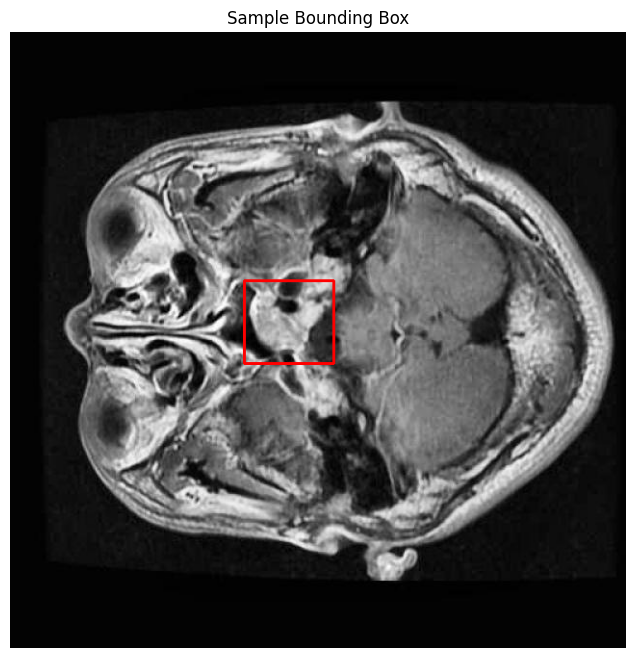

In [34]:
import json, cv2, random
import matplotlib.pyplot as plt

train_ann = "../dataset/train/_annotations.coco.json"
with open(train_ann, "r") as f:
    coco = json.load(f)

img_meta = random.choice(coco["images"])
fn = img_meta["file_name"]

img_path = f"../dataset/train/images/{fn}"
img = cv2.imread(img_path)
assert img is not None, f"Missing image: {img_path}"

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def draw_box(img, bbox, color=(255,0,0)):
    x,y,w,h = map(int,bbox)
    cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)

anns = [a for a in coco["annotations"] if a["image_id"]==img_meta["id"]]
for ann in anns:
    draw_box(img, ann["bbox"])

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Bounding Box")
plt.show()

Convert COCO → YOLO

In [35]:
import json, os

def coco_to_yolo(coco_json_path, images_dir, labels_dir, class_id=0):
    os.makedirs(labels_dir, exist_ok=True)
    coco = json.load(open(coco_json_path, "r"))

    sizes = {
        img["id"]: (img["width"], img["height"], img["file_name"])
        for img in coco["images"]
    }

    ann_by_img = {}
    for ann in coco["annotations"]:
        ann_by_img.setdefault(ann["image_id"], []).append(ann)

    count = 0

    for img_id, anns in ann_by_img.items():
        w, h, fname = sizes[img_id]

        lab = fname.rsplit(".",1)[0] + ".txt"
        out = os.path.join(labels_dir, lab)

        with open(out, "w") as f:
            for ann in anns:
                x,y,bw,bh = ann["bbox"]

                cx = (x + bw/2) / w
                cy = (y + bh/2) / h
                nw = bw / w
                nh = bh / h

                f.write(f"{class_id} {cx} {cy} {nw} {nh}\n")

        count += 1

    print(f"Converted {count} labels → {labels_dir}")

Run conversion (train, valid, test)

In [36]:
root = "../dataset"

coco_to_yolo(
    f"{root}/train/_annotations.coco.json",
    f"{root}/train/images",
    f"{root}/train/labels"
)

coco_to_yolo(
    f"{root}/valid/_annotations.coco.json",
    f"{root}/valid/images",
    f"{root}/valid/labels"
)

os.makedirs(f"{root}/test/labels", exist_ok=True)
print("Prepared test labels.")

Converted 1501 labels → ../dataset/train/labels
Converted 429 labels → ../dataset/valid/labels
Prepared test labels.


Clean corrupted labels

In [37]:
train_images = "../dataset/train/images"
train_labels = "../dataset/train/labels"

deleted = 0

for txt in os.listdir(train_labels):
    if not txt.endswith(".txt"):
        continue
    base = txt[:-4]

    candidates = [base + ext for ext in [".jpg",".jpeg",".png"]]

    exists = any(os.path.exists(os.path.join(train_images, c)) for c in candidates)
    if not exists:
        os.remove(os.path.join(train_labels, txt))
        deleted += 1

print("Deleted corrupted labels:", deleted)

Deleted corrupted labels: 0


Delete .cache before training

In [38]:
import glob

for cache in glob.glob("../dataset/**/*.cache", recursive=True):
    print("Deleting:", cache)
    os.remove(cache)

print("Cache cleared.")

Cache cleared.


Train YOLOv8s (correct dirs)

In [39]:
# from ultralytics import YOLO

# yaml_path = "../dataset/dataset.yaml"
# assert os.path.exists(yaml_path)

# model = YOLO("yolov8s.pt")

# results = model.train(
#     data=yaml_path,
#     epochs=25,
#     imgsz=640,
#     batch=16,
#     patience=10,
#     device=device,
#     workers=4,
#     project="../experiments",
#     name="yolo_run7",
#     save=True,
#     save_period=1
# )

# print("Training complete → ../experiments/yolo_run7")

In [40]:
from ultralytics import YOLO

yaml_path = "../dataset/dataset.yaml"
assert os.path.exists(yaml_path)

model = YOLO("yolov8s.pt")

results = model.train(
    data="../dataset/dataset.yaml",
    epochs=30,
    imgsz=640,
    batch=8,
    device=device,
    project="../experiments",
    name="yolo_seg_fixed",

    # ONLY AUGMENTATIONS SAFE IN YOUR VERSION
    fliplr=0.5,
    flipud=0.0,

    # FORCE all other augmentations OFF using the global switch
    augment=False
)

print("Training complete → ../experiments/yolo_run7")

Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 MPS (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../dataset/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_seg_fixed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

 Run prediction on VALID set (save predicted boxes)

In [52]:
!yolo predict \
    model=../experiments/yolo_seg_fixed/weights/best.pt \
    source=../dataset/valid/images \
    save_txt=True \
    save_conf=False \
    conf=0.0 \
    project=../experiments \
    name=yolo_seg_fixed_val_preds

Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1001_jpg.rf.a64df329f81626672c9b81f95d421c84.jpg: 640x640 300 tumors, 67.0ms
image 2/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1006_jpg.rf.9e260b2c3d87e68b706022359921b4e0.jpg: 640x640 300 tumors, 71.1ms
image 3/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1007_jpg.rf.bf4640f845748bd0c7fe976a3c5e521e.jpg: 640x640 300 tumors, 60.7ms
image 4/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1009_jpg.rf.230f70b84d8d461b7c40b7ce30cd0ced.jpg: 640x640 300 tumors, 59.0ms
image 

Load the segmentation model

In [60]:
model = YOLO("../experiments/yolo_seg_fixed/weights/best.pt")
print("Model loaded.")

Model loaded.


 Collect validation images

In [61]:
val_dir = "../dataset/valid/images"
image_paths = sorted([
    os.path.join(val_dir, f) 
    for f in os.listdir(val_dir) 
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

print(f"Found {len(image_paths)} validation images.")

Found 429 validation images.


Output directory for the 1-box predictions

In [62]:
out_dir = "../experiments/fixed_onebox_preds"
labels_dir = os.path.join(out_dir, "labels")

os.makedirs(labels_dir, exist_ok=True)

print("Output directory:", labels_dir)

Output directory: ../experiments/fixed_onebox_preds/labels


Helper: extract best box from YOLO-seg output

In [63]:
def extract_best_box(result):
    """Return (cls, conf, xywh) for the best box or None."""
    if result.boxes is None or len(result.boxes) == 0:
        return None
    
    best = max(result.boxes, key=lambda b: float(b.conf))
    
    cls_id = int(best.cls[0].item())
    conf   = float(best.conf[0].item())
    xywh   = best.xywh[0].cpu().tolist()  # normalized xywh
    
    return cls_id, conf, xywh

Run inference image-by-image (MPS enabled)

In [64]:
for img_path in image_paths:
    results = model.predict(
        source=img_path,
        device="mps",         # <-- USE APPLE GPU
        imgsz=640,
        verbose=False
    )
    
    result = results[0]
    best = extract_best_box(result)

    # txt filename
    base = os.path.splitext(os.path.basename(img_path))[0]
    txt_path = os.path.join(labels_dir, base + ".txt")

    if best is None:
        # no boxes → empty file
        open(txt_path, "w").close()
        continue

    cls_id, conf, xywh = best
    x, y, w, h = xywh

    # ignore confidence in txt files (but you can include it if needed)
    line = f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n"

    with open(txt_path, "w") as f:
        f.write(line)

print("Done. One predicted box saved per image.")

Done. One predicted box saved per image.


 Quick check of generated labels

In [67]:
import random

sample = random.choice(os.listdir(labels_dir))
print("Example file:", sample)

with open(os.path.join(labels_dir, sample)) as f:
    print(f.read())

Example file: 1680_jpg.rf.dc955793113d21ed2406b8c56e20e32d.txt
0 298.782349 285.886902 118.137939 104.176773



 IoU function

In [ ]:
def iou_yolo(box1, box2):
    """Compute IoU between two YOLO-normalized boxes (xywh)."""

    # xywh → xyxy
    def to_xyxy(x, y, w, h):
        x1 = x - w/2
        y1 = y - h/2
        x2 = x + w/2
        y2 = y + h/2
        return x1, y1, x2, y2
    
    x1_1, y1_1, x2_1, y2_1 = to_xyxy(*box1)
    x1_2, y1_2, x2_2, y2_2 = to_xyxy(*box2)

    # intersection
    ix1 = max(x1_1, x1_2)
    iy1 = max(y1_1, y1_2)
    ix2 = min(x2_1, x2_2)
    iy2 = min(y2_1, y2_2)

    iw = max(0, ix2 - ix1)
    ih = max(0, iy2 - iy1)
    inter = iw * ih

    # union
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - inter + 1e-9

    return inter / union

 Evaluate IoU for every image

In [ ]:
results = []

for gt_path in gt_files:
    fname = os.path.basename(gt_path)
    pred_path = os.path.join(pred_dir, fname)

    # prediction file missing
    if not os.path.exists(pred_path):
        results.append([fname, None])
        continue

    # Read GT
    with open(gt_path) as f:
        gt_lines = [l.strip() for l in f.readlines() if l.strip()]

    # No GT → IoU undefined
    if len(gt_lines) == 0:
        results.append([fname, None])
        continue

    # Use FIRST GT box (your dataset has exactly one)
    _, gx, gy, gw, gh = map(float, gt_lines[0].split())

    # Read prediction
    with open(pred_path) as f:
        pred_lines = [l.strip() for l in f.readlines() if l.strip()]

    if len(pred_lines) == 0:
        results.append([fname, 0.0])   # no prediction → IoU = 0
        continue

    _, px, py, pw, ph = map(float, pred_lines[0].split())

    # Compute IoU
    iou = iou_yolo((gx, gy, gw, gh), (px, py, pw, ph))
    results.append([fname, iou])

ValueError: too many values to unpack (expected 5)